In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


In [4]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [6]:
df.shape

(17414, 10)

In [9]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:17414, 1:2]

In [10]:
print(train.shape)
print(test.shape)

(17000, 1)
(414, 1)


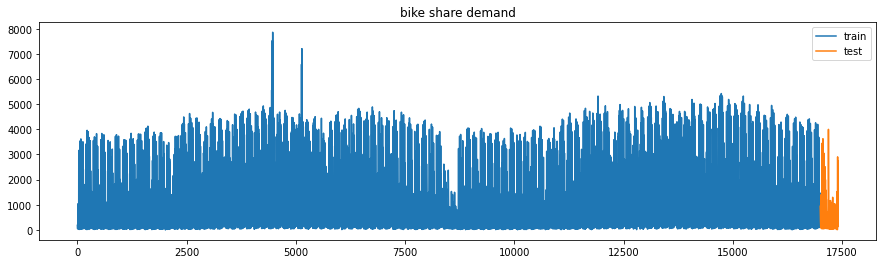

In [11]:
df['cnt'][:17000].plot(figsize=(15,4), legend=True)
df['cnt'][17000:].plot(figsize=(15,4), legend=True)
plt.legend(['train', 'test'])
plt.title('bike share demand')
plt.show()

In [21]:
from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags=20, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713]


<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

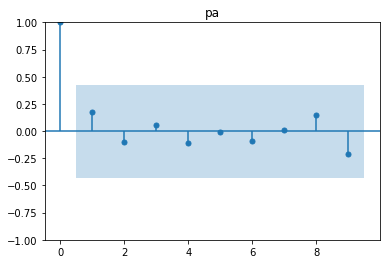

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=9, method='ols', title='pa').show

In [24]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)

In [26]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [28]:
X_train = []
y_train = []

for i in range(1, 17000):
    X_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [29]:
X_train.shape

(16999, 1)

In [34]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(16999, 1, 1)

In [35]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN



In [37]:
rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1))

In [38]:
print(rnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 6)                 48        
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [40]:
rnn.fit(X_train, y_train, batch_size=1, epochs=2)

2022-09-14 06:46:12.178008: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
16999/16999 [==============================] - 26s 1ms/step - loss: 0.0075 - mse: 0.0075
Epoch 2/2
16999/16999 [==============================] - 24s 1ms/step - loss: 0.0068 - mse: 0.0068


In [43]:
inputs= sc.transform(test)
inputs.shape

(414, 1)

In [44]:
X_test = []
inputs.shape

(414, 1)

In [46]:
X_test = []
for i in range(1, 415):
    X_test.append(inputs[i-1:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(414, 1, 1)

In [47]:
rnn = rnn.predict(X_test)
rnn = sc.inverse_transform(rnn)

In [48]:
test1 = pd.DataFrame(test)
rnn = pd.DataFrame(rnn)

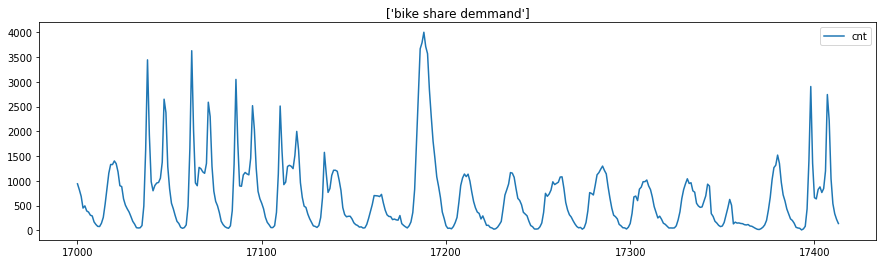

In [49]:
test1.plot(figsize= (15, 4), legend=True)
plt.legend(['cnt'])
plt.title(['bike share demmand'])
plt.show()

In [50]:
test = np.array(test)

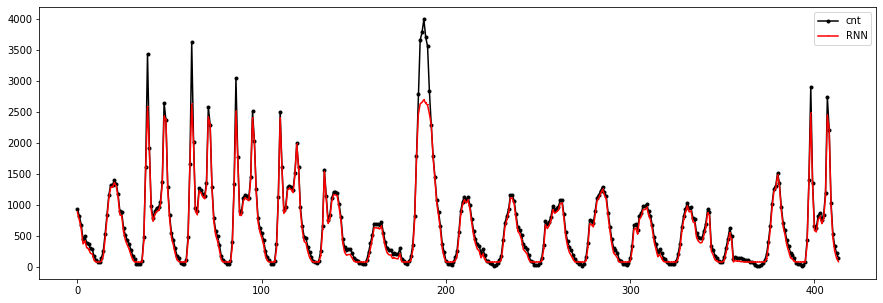

In [54]:
plt.figure(figsize=(15,5))
plt.plot(test, marker=".", label = 'cnt', color='black')
plt.plot(rnn, marker=",", label = 'RNN', color='red')
plt.legend()

In [56]:
from keras.layers.recurrent import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1,1)))
lstm.add(Dense(units=1, activation='linear'))

In [57]:
print(lstm.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 35s 2ms/step - loss: 0.0086 - mse: 0.0086
Epoch 2/2
16999/16999 [==============================] - 35s 2ms/step - loss: 0.0068 - mse: 0.0068


In [62]:
lstm = lstm.predict(X_test)
lstm = sc.inverse_transform(lstm)

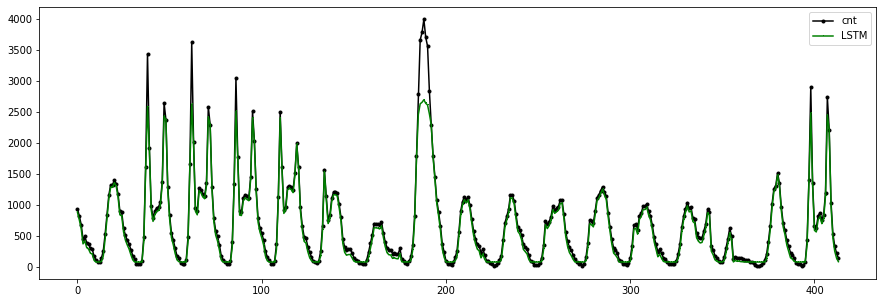

In [63]:
plt.figure(figsize=(15,5))
plt.plot(test, marker=".", label = 'cnt', color='black')
plt.plot(rnn, marker=",", label = 'LSTM', color='green')
plt.legend()

In [64]:
from keras.layers.recurrent import GRU
gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation='linear'))

In [65]:
print(gru.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 36s 2ms/step - loss: 0.0076 - mse: 0.0076
Epoch 2/2
16999/16999 [==============================] - 34s 2ms/step - loss: 0.0068 - mse: 0.0068


In [70]:
gru = gru.predict(X_test)
gru = sc.inverse_transform(gru)


AttributeError: 'numpy.ndarray' object has no attribute 'predict'

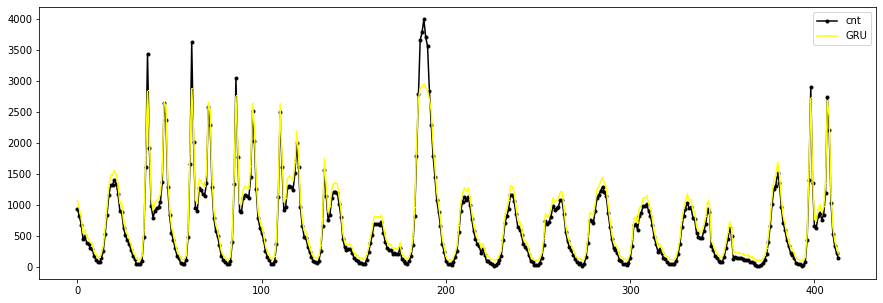

In [71]:
plt.figure(figsize=(15,5))
plt.plot(test, marker=".", label = 'cnt', color='black')
plt.plot(gru, marker=",", label = 'GRU', color='yellow')
plt.legend()

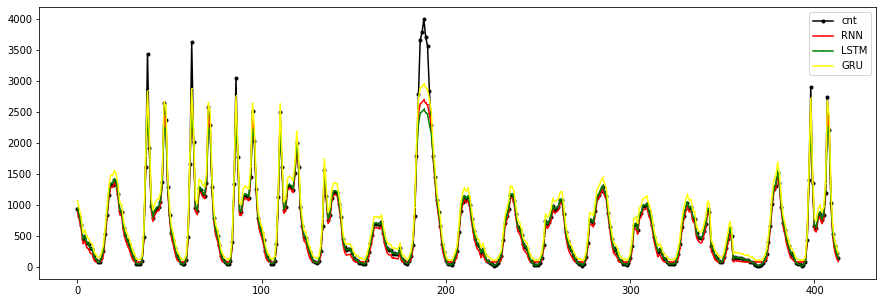

In [73]:
 plt.figure(figsize=(15,5))
plt.plot(test, marker=".", label = 'cnt', color='black')
plt.plot(rnn, marker=",", label = 'RNN', color='red')
plt.plot(lstm, marker=",", label = 'LSTM', color='green')
plt.plot(gru, marker=",", label = 'GRU', color='yellow')
plt.legend()

In [75]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [76]:
print("RNN RMSE:", RMSE(test, rnn))

RNN RMSE: 155.43338032435176


In [79]:
print("LSTM RMSE:", RMSE(test, lstm))

LSTM RMSE: 172.39009261747358


In [78]:
print("GRU RMSE:", RMSE(test, gru))

GRU RMSE: 150.86313360840794


In [ ]:
# 실제 값과 예측값의 차이가 적을수로 좋으니 위에서는 현재 lstm이 성능이 가장 좋게 나오고 있다. 